In [1]:
import pandas as pd

In [75]:
df = pd.read_csv('all_exp_df.csv')
df = df.drop(columns=[c for c in df.columns if 'Unnamed' in c])
df

,test_classifier_fit_time,test_feature_selector_fit_time,test_acc,test_mcc,test_roc_auc,test_pr_auc,test_mean_inference_time,dataset,n_samples,n_features_org,cv_method,learning_algorithm,filtering_algorithm,n_selected_features,selected_features_names,selected_features_scores
0,0.001552,0.014603,0.930556,0.848620,0.952340,0.958263,0.000714,ALLAML.csv,72,7129,LeaveOneOut(),GaussianNB,select_fdr_fs,1,1881,216.7237
1,0.001559,0.015855,0.958333,0.907651,0.994043,0.989402,0.000695,ALLAML.csv,72,7129,LeaveOneOut(),GaussianNB,select_fdr_fs,2,"1881,2287","216.7237,198.9983"
2,0.001659,0.017396,0.930556,0.848620,0.993191,0.988151,0.000736,ALLAML.csv,72,7129,LeaveOneOut(),GaussianNB,select_fdr_fs,3,"1881,2287,3251","216.7237,198.9983,185.3939"
3,0.001565,0.013124,0.958333,0.907651,0.993191,0.988151,0.000700,ALLAML.csv,72,7129,LeaveOneOut(),GaussianNB,select_fdr_fs,4,"1881,2287,3251,1833","216.7237,198.9983,185.3939,174.7985"
4,0.001660,0.014022,0.944444,0.877447,0.994894,0.990794,0.000736,ALLAML.csv,72,7129,LeaveOneOut(),GaussianNB,select_fdr_fs,5,"1881,2287,3251,1833,4846","216.7237,198.9983,185.3939,174.7985,155.4472"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78475,0.015377,0.005109,1.000000,1.000000,1.000000,1.000000,0.004787,christensen_inputs.csv,217,1413,"StratifiedKFold(n_splits=10, random_state=42, ...",SVC,svm_fs,100,"39,366,592,410,673,195,1068,109,1126,496,72,13...","1.0000,0.9993,0.9986,0.9979,0.9972,0.9965,0.99..."
78476,0.016236,0.005558,1.000000,1.000000,1.000000,1.000000,0.004520,christensen_inputs.csv,217,1413,"StratifiedKFold(n_splits=10, random_state=42, ...",SVC,svm_fs,100,"39,673,410,955,752,1393,710,514,594,496,61,132...","1.0000,0.9993,0.9986,0.9979,0.9972,0.9965,0.99..."
78477,0.015437,0.005448,1.000000,1.000000,1.000000,1.000000,0.004539,christensen_inputs.csv,217,1413,"StratifiedKFold(n_splits=10, random_state=42, ...",SVC,svm_fs,100,"710,673,1393,1307,72,341,1068,1324,722,39,195,...","1.0000,0.9993,0.9986,0.9979,0.9972,0.9965,0.99..."
78478,0.016141,0.005729,1.000000,1.000000,1.000000,1.000000,0.004877,christensen_inputs.csv,217,1413,"StratifiedKFold(n_splits=10, random_state=42, ...",SVC,svm_fs,100,"1393,673,592,405,481,410,72,955,6,976,1128,594...","1.0000,0.9993,0.9986,0.9979,0.9972,0.9965,0.99..."


# Accuracy

In [30]:
mean_acc = df.groupby(['dataset', 'filtering_algorithm', 'n_selected_features']).mean()['test_acc'].reset_index()

max_acc = mean_acc.groupby('dataset').max()['test_acc'].reset_index()

max_acc = max_acc.apply(
    lambda row: mean_acc[(mean_acc['dataset'] == row['dataset']) & (mean_acc['test_acc'] == row['test_acc'])].iloc[0],
    axis=1)
max_acc

,dataset,filtering_algorithm,n_selected_features,test_acc
0,ALL.csv,grey_wolf_fs,4.0,0.799744
1,ALLAML.csv,rfe_svm_fs,25.0,1.000000
2,BASEHOCK.csv,mrmr_fs,100.0,0.951636
3,Breast.csv,svm_fs_New,100.0,0.975258
4,CLL-SUB-111.csv,poly_svm_fs_New,100.0,0.822121
5,CLL.csv,rfe_svm_fs,100.0,1.000000
6,CNS.csv,svm_fs_New,20.0,0.943333
7,COIL20.csv,svm_fs,100.0,0.967639
8,FSH.csv,svm_fs,100.0,0.800000
9,Lung.csv,rfe_svm_fs,50.0,0.918947


In [94]:
metric_col = 'test_acc'

res = {d: {} for d in df.dataset.unique()}
improvements_fs = list(df['filtering_algorithm'][df['filtering_algorithm'].str.endswith('_New')].unique())
for new_fs in improvements_fs:
    org_fs = new_fs[:-len('_New')]
    mean_df = df[df['filtering_algorithm'].isin([org_fs,new_fs])].groupby(['dataset', 'filtering_algorithm']).mean()[metric_col].reset_index()
    for dataset in mean_df.dataset.unique():
        ds_df = mean_df[mean_df['dataset'] == dataset]
        org_metric = ds_df[ds_df['filtering_algorithm'] == org_fs][metric_col].iloc[0]
        new_metric = ds_df[ds_df['filtering_algorithm'] == new_fs][metric_col].iloc[0]
        if new_metric > org_metric:
            res[dataset].update({f'better_{org_fs}': 'Improved', f'better_{org_fs}_percentage': 100 * (new_metric / org_metric - 1)})
        elif new_metric < org_metric:
            res[dataset].update({f'better_{org_fs}': 'Original', f'better_{org_fs}_percentage': 100 * (org_metric / new_metric - 1)})
        else:
            res[dataset].update({f'better_{org_fs}': 'Equal'})
res_df = pd.DataFrame([{'dataset': d, **v} for d, v in res.items()])
res_df

,dataset,better_grey_wolf_fs,better_grey_wolf_fs_percentage,better_poly_svm_fs,better_poly_svm_fs_percentage,better_rbf_svm_fs,better_rbf_svm_fs_percentage,better_svm_fs,better_svm_fs_percentage
0,ALLAML.csv,Improved,1.966874,Improved,0.023810,Improved,2.539448,Original,0.662565
1,ALL.csv,Improved,0.173183,Original,0.902310,Original,0.998059,Original,1.310319
2,ayeastCC.csv,Improved,1.321928,Equal,NaN,Improved,0.170416,Equal,NaN
3,bcellViper.csv,Improved,0.799619,Original,1.026795,Improved,0.232158,Original,0.689465
4,bladderbatch.csv,Improved,2.373129,Original,4.975288,Original,2.500000,Improved,1.061174
5,Breast.csv,Original,3.280225,Original,0.467955,Original,1.593049,Improved,1.765873
6,CLL.csv,Improved,1.440922,Original,1.357827,Original,0.789266,Improved,0.077882
7,CLL-SUB-111.csv,Original,7.454214,Improved,0.084163,Improved,0.050495,Original,6.540544
8,CNS.csv,Improved,3.315714,Improved,0.547383,Improved,0.482375,Improved,2.595269
9,COIL20.csv,Original,2.077392,Original,1.090964,Original,0.014127,Improved,1.682926


In [95]:
metric_col = 'test_acc'

res = {d: {} for d in df.dataset.unique()}
improvements_fs = list(df['filtering_algorithm'][df['filtering_algorithm'].str.endswith('_Aug')].unique())
for new_fs in improvements_fs:
    org_fs = new_fs[:-len('_Aug')]
    mean_df = df[df['filtering_algorithm'].isin([org_fs,new_fs])].groupby(['dataset', 'filtering_algorithm']).mean()[metric_col].reset_index()
    for dataset in mean_df.dataset.unique():
        ds_df = mean_df[mean_df['dataset'] == dataset]
        org_metric = ds_df[ds_df['filtering_algorithm'] == org_fs][metric_col].iloc[0]
        new_metric = ds_df[ds_df['filtering_algorithm'] == new_fs][metric_col].iloc[0]
        if new_metric > org_metric:
            res[dataset].update({f'better_{org_fs}': 'Augmented', f'better_{org_fs}_percentage': 100 * (new_metric / org_metric - 1)})
        elif new_metric < org_metric:
            res[dataset].update({f'better_{org_fs}': 'Original', f'better_{org_fs}_percentage': 100 * (org_metric / new_metric - 1)})
        else:
            res[dataset].update({f'better_{org_fs}': 'Equal'})
res_df = pd.DataFrame([{'dataset': d, **v} for d, v in res.items()])
res_df

,dataset
0,ALLAML.csv
1,ALL.csv
2,ayeastCC.csv
3,bcellViper.csv
4,bladderbatch.csv
5,Breast.csv
6,CLL.csv
7,CLL-SUB-111.csv
8,CNS.csv
9,COIL20.csv


# Fit time

In [53]:
metric_col = 'test_feature_selector_fit_time'
mean_acc = df.groupby(['dataset', 'filtering_algorithm']).max()[metric_col].reset_index()

max_acc = mean_acc.groupby(['dataset']).min()[metric_col].reset_index()

max_acc = max_acc.apply(lambda row: mean_acc[(mean_acc['dataset'] == row['dataset'])
                                             & (mean_acc[metric_col] == row[metric_col])].iloc[0], axis=1)
max_acc

C:\Users\adutl\AppData\Local\Temp\ipykernel_10932\877760687.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  mean_acc = df.groupby(['dataset', 'filtering_algorithm']).max()[metric_col].reset_index()


,dataset,filtering_algorithm,test_feature_selector_fit_time
0,ALL.csv,select_fdr_fs,0.183367
1,ALLAML.csv,select_fdr_fs,0.075487
2,BASEHOCK.csv,select_fdr_fs,1.473152
3,Breast.csv,select_fdr_fs,0.189027
4,CLL-SUB-111.csv,select_fdr_fs,0.091319
5,CLL.csv,select_fdr_fs,0.025800
6,CNS.csv,select_fdr_fs,0.046296
7,COIL20.csv,select_fdr_fs,0.105482
8,FSH.csv,select_fdr_fs,0.012692
9,Lung.csv,select_fdr_,0.197585


In [96]:
metric_col = 'test_feature_selector_fit_time'

res = {d: {} for d in df.dataset.unique()}
improvements_fs = list(df['filtering_algorithm'][df['filtering_algorithm'].str.endswith('_New')].unique())
for new_fs in improvements_fs:
    org_fs = new_fs[:-len('_New')]
    mean_df = df[df['filtering_algorithm'].isin([org_fs,new_fs])].groupby(['dataset', 'filtering_algorithm']).max()[metric_col].reset_index()
    for dataset in mean_df.dataset.unique():
        ds_df = mean_df[mean_df['dataset'] == dataset]
        org_metric = ds_df[ds_df['filtering_algorithm'] == org_fs][metric_col].iloc[0]
        new_metric = ds_df[ds_df['filtering_algorithm'] == new_fs][metric_col].iloc[0]
        if new_metric < org_metric:
            res[dataset].update({f'better_{org_fs}': 'Improved', f'better_{org_fs}_percentage': 100 * (1 - new_metric / org_metric)})
        elif new_metric > org_metric:
            res[dataset].update({f'better_{org_fs}': 'Original', f'better_{org_fs}_percentage': 100 * (1 - org_metric / new_metric)})
        else:
            res[dataset].update({f'better_{org_fs}': 'Equal'})
res_df = pd.DataFrame([{'dataset': d, **v} for d, v in res.items()])
res_df

,dataset,better_grey_wolf_fs,better_grey_wolf_fs_percentage,better_poly_svm_fs,better_poly_svm_fs_percentage,better_rbf_svm_fs,better_rbf_svm_fs_percentage,better_svm_fs,better_svm_fs_percentage
0,ALLAML.csv,Improved,15.164895,Improved,99.809068,Improved,99.810553,Improved,99.770364
1,ALL.csv,Original,34.436158,Improved,99.969945,Improved,99.866910,Improved,99.864731
2,ayeastCC.csv,Original,37.892492,Improved,99.363202,Improved,99.490962,Improved,96.809083
3,bcellViper.csv,Improved,9.016562,Improved,99.836126,Improved,99.851095,Improved,99.731192
4,bladderbatch.csv,Improved,38.928728,Improved,99.954906,Improved,99.934598,Improved,99.936092
5,Breast.csv,Improved,38.713405,Improved,99.942971,Improved,99.955716,Improved,99.919753
6,CLL.csv,Original,7.390204,Improved,99.150607,Improved,99.326679,Improved,98.863130
7,CLL-SUB-111.csv,Original,0.378930,Improved,99.938270,Improved,99.892423,Improved,99.911170
8,CNS.csv,Improved,41.641027,Improved,99.732202,Improved,99.736990,Improved,99.623953
9,COIL20.csv,Original,80.587979,Improved,97.286345,Improved,98.991579,Improved,98.616409


In [97]:
metric_col = 'test_feature_selector_fit_time'

res = {d: {} for d in df.dataset.unique()}
improvements_fs = list(df['filtering_algorithm'][df['filtering_algorithm'].str.endswith('_Aug')].unique())
for new_fs in improvements_fs:
    org_fs = new_fs[:-len('_Aug')]
    mean_df = df[df['filtering_algorithm'].isin([org_fs,new_fs])].groupby(['dataset', 'filtering_algorithm']).max()[metric_col].reset_index()
    for dataset in mean_df.dataset.unique():
        ds_df = mean_df[mean_df['dataset'] == dataset]
        org_metric = ds_df[ds_df['filtering_algorithm'] == org_fs][metric_col].iloc[0]
        new_metric = ds_df[ds_df['filtering_algorithm'] == new_fs][metric_col].iloc[0]
        if new_metric < org_metric:
            res[dataset].update({f'better_{org_fs}': 'Augmented', f'better_{org_fs}_percentage': 100 * (1 - new_metric / org_metric)})
        elif new_metric > org_metric:
            res[dataset].update({f'better_{org_fs}': 'Original', f'better_{org_fs}_percentage': 100 * (1 - org_metric / new_metric)})
        else:
            res[dataset].update({f'better_{org_fs}': 'Equal'})
res_df = pd.DataFrame([{'dataset': d, **v} for d, v in res.items()])
res_df

,dataset
0,ALLAML.csv
1,ALL.csv
2,ayeastCC.csv
3,bcellViper.csv
4,bladderbatch.csv
5,Breast.csv
6,CLL.csv
7,CLL-SUB-111.csv
8,CNS.csv
9,COIL20.csv


# Friedman PostHoc Test

rejected null hypothesis
algorithm poly_svm_fs is significantly better than algorithms {'svm_fs_New', 'mrmr_fs', 'svm_fs', 'rbf_svm_fs', 'rbf_svm_fs_New', 'reliefF_fs', 'grey_wolf_fs_New', 'select_fdr_fs', 'rfe_svm_fs', 'grey_wolf_fs'} in terms of test_roc_auc
algorithm poly_svm_fs_New is significantly better than algorithms {'svm_fs_New', 'mrmr_fs', 'svm_fs', 'rbf_svm_fs', 'rbf_svm_fs_New', 'reliefF_fs', 'grey_wolf_fs_New', 'select_fdr_fs', 'rfe_svm_fs', 'grey_wolf_fs'} in terms of test_roc_auc
algorithm rbf_svm_fs is significantly better than algorithms {'grey_wolf_fs', 'mrmr_fs', 'grey_wolf_fs_New'} in terms of test_roc_auc
algorithm rbf_svm_fs_New is significantly better than algorithms {'grey_wolf_fs', 'mrmr_fs', 'grey_wolf_fs_New'} in terms of test_roc_auc
algorithm reliefF_fs is significantly better than algorithms {'rfe_svm_fs', 'grey_wolf_fs', 'mrmr_fs', 'grey_wolf_fs_New'} in terms of test_roc_auc
algorithm rfe_svm_fs is significantly better than algorithms {'grey_wolf_fs', '

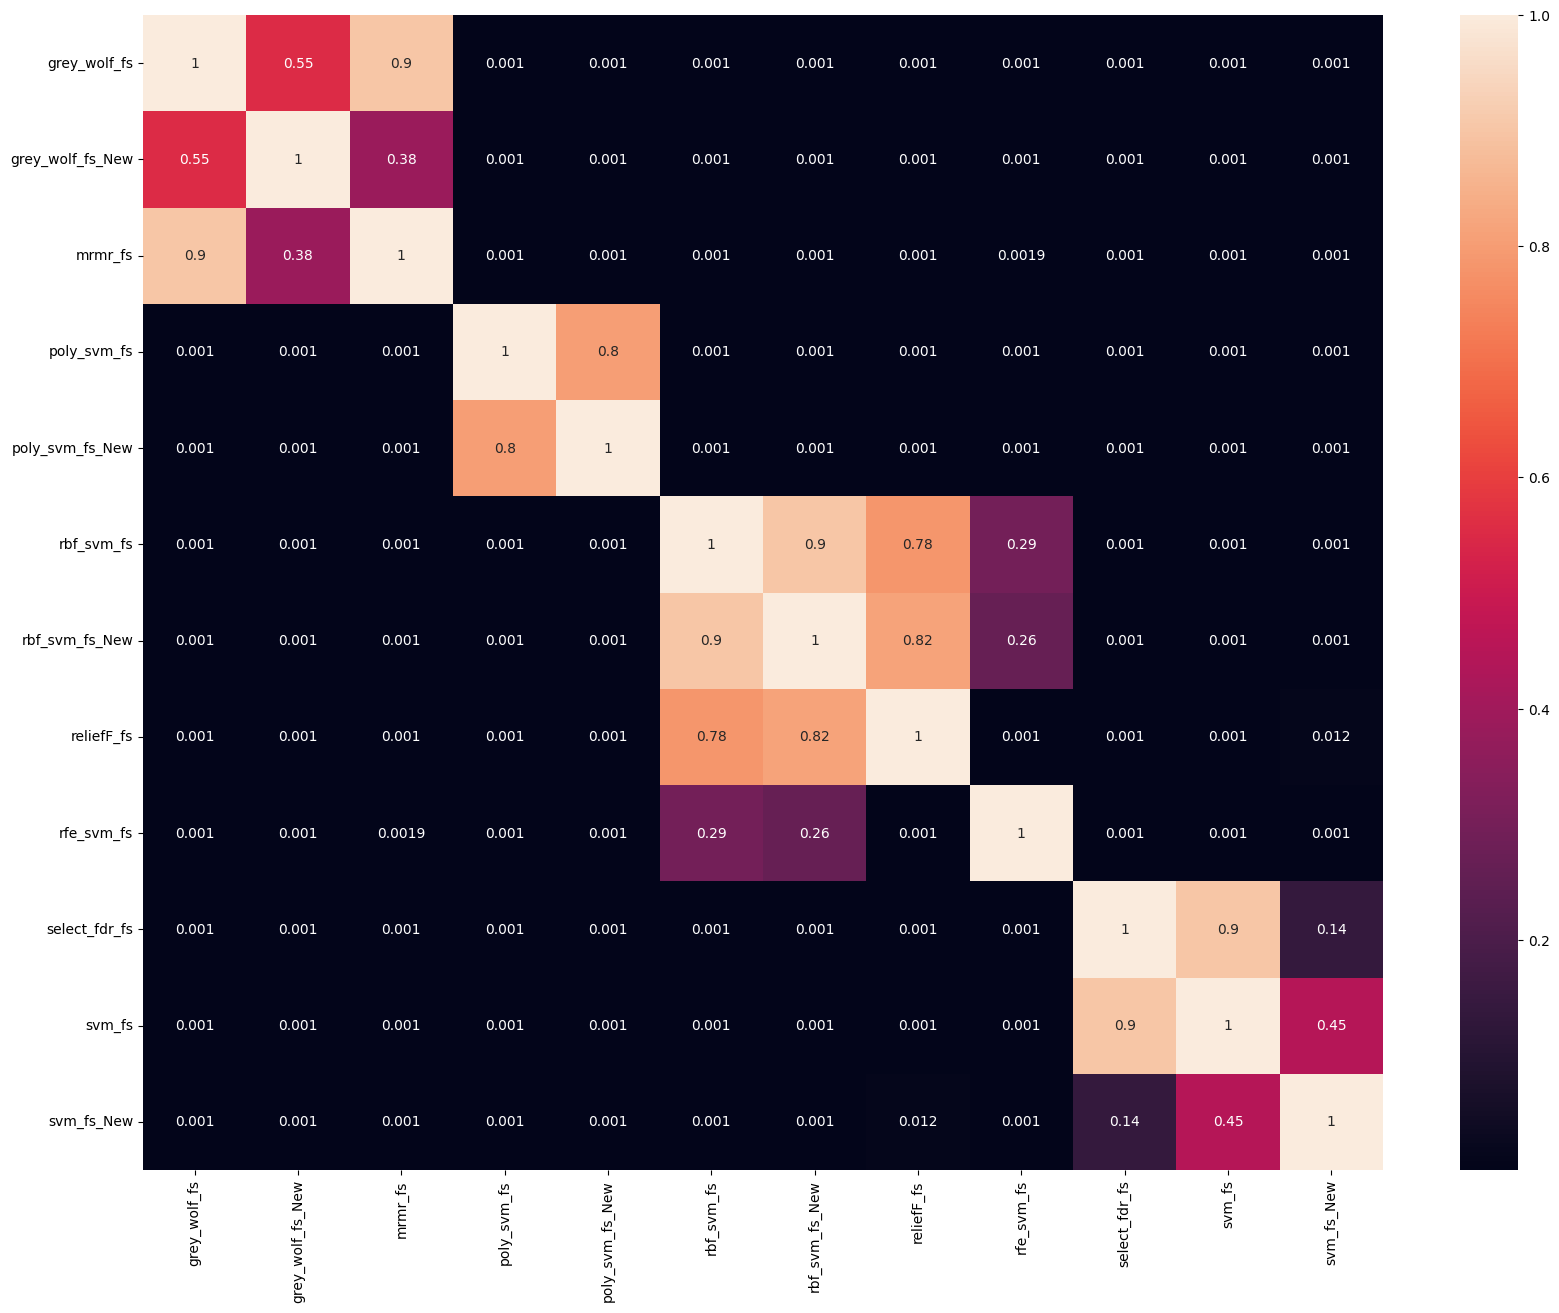

In [52]:
from friedman_posthoc_test import friedman_posthoc_test
friedman_posthoc_test('all_exp_df.csv')